# Cognitive, behavioral and social data
**Author**: Mattia Brocco

In [1]:
import os

# COPIA QUI LA DIRECTORY DOVE HAI R
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.0.2"
#os.environ["R_LIBS_USER"] = r"C:/Program Files/R/R-4.0.2/library/stats/libs/x64"

import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import support
import evaluation
import pca_engine
import summary_graphs
from engine import Classification

%load_ext autoreload
%autoreload 2

data_dir = ".\\data"

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 500

### Datasets at hand

In [2]:
#data_descr = pd.DataFrame(dict(zip([f for f in os.listdir(data_dir) if "parquet" in f],
#                                   [pd.read_parquet(f"{data_dir}\\{f}").shape for f in os.listdir(data_dir)
#                                    if "parquet" in f]))).T.reset_index()
#data_descr = data_descr.rename(columns = {"index": "Data", 0: "Sample size",
#                                          1: "Features"})
#data_descr

## Principal Components Analysis (PCA)

In [3]:
data_collection_pca = {}
for dataset in [f for f in os.listdir(data_dir) if "parquet" in f]:
    print(dataset.split(".")[0])
    
    data_iter = pca_engine.prepare_data(f"{data_dir}\\{dataset}", "CONDITION")
    data_mwu = pca_engine.new_mwu_data(data_iter)
    #pca_engine.scree_plot(data_mwu)
    
    var_sel = pca_engine.pca_ds_acc(data_mwu)
    X_tr, X_ts, y_tr, y_ts = pca_engine.trts_split(data_mwu)
    
    perfs, stability = Classification().benchmark_models(X_tr, X_ts, y_tr, y_ts, var_sel)
    
    data_collection_pca[dataset.split(".")[0]] = [X_tr, X_ts, y_tr, y_ts, var_sel, perfs, stability]

BF_df_CTU


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 309
Selected 2 features out of 8
BF_df_OU


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 2ms/step
Train size: 322
Selected 2 features out of 9
BF_df_V


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 340
Selected 2 features out of 9
DT_df_CC


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 337
Selected 4 features out of 18
DT_df_JI


  0%|          | 0/100 [00:00<?, ?it/s]

9/9 [==============================] - 0s 997us/step
Train size: 604
Selected 3 features out of 15
IADQ_df


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 315
Selected 2 features out of 9
IESR_df


  0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step
Train size: 250
Selected 4 features out of 21
NAQ_R_df


  0%|          | 0/100 [00:00<?, ?it/s]

7/7 [==============================] - 0s 1ms/step
Train size: 498
Selected 5 features out of 22
PCL5_df


  0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step
Train size: 281
Selected 4 features out of 20
PHQ9_GAD7_df


  0%|          | 0/100 [00:00<?, ?it/s]

11/11 [==============================] - 0s 898us/step
Train size: 782
Selected 3 features out of 16
PID5_df


  0%|          | 0/100 [00:00<?, ?it/s]

8/8 [==============================] - 0s 1ms/step
Train size: 576
Selected 42 features out of 210
PRFQ_df


  0%|          | 0/100 [00:00<?, ?it/s]

7/7 [==============================] - 0s 1ms/step
Train size: 474
Selected 3 features out of 15
PRMQ_df


  0%|          | 0/100 [00:00<?, ?it/s]

14/14 [==============================] - 0s 1ms/step
Train size: 982
Selected 3 features out of 16
RAW_DDDT


  0%|          | 0/100 [00:00<?, ?it/s]

10/10 [==============================] - 0s 911us/step
Train size: 690
Selected 3 features out of 12
R_NEO_PI


  0%|          | 0/100 [00:00<?, ?it/s]

729/729 [==============================] - 1s 926us/step
Train size: 54380
Selected 5 features out of 30
sPID-5_df


  0%|          | 0/100 [00:00<?, ?it/s]

10/10 [==============================] - 0s 1ms/step
Train size: 726
Selected 5 features out of 25


In [4]:
pca_summary = evaluation.summary_table(data_collection_pca, stability = True, neural_net = True)
pca_summary

,Dataset name,Sample size,Training size,Number of Features,Selected Features,Feat. Top5-Stability,Accuracy - Logit all features,Accuracy - Logit,Accuracy - SVM,Accuracy - RF,Accuracy - MLP,Avg Acc. on selected features,Accuracy Std on selected features,Acc. diff. wrt Full logit
0,BF_df_CTU,442,309,8,2,1.000,0.774,0.737,0.737,0.737,0.737,0.737,0.000,-0.038
1,BF_df_OU,460,322,9,2,1.000,0.833,0.674,0.667,0.681,0.681,0.676,0.007,-0.158
2,BF_df_V,486,340,9,2,1.000,0.753,0.692,0.685,0.685,0.699,0.690,0.007,-0.063
3,DT_df_CC,482,337,18,4,0.583,0.703,0.641,0.655,0.648,0.538,0.621,0.055,-0.083
4,DT_df_JI,864,604,15,3,0.778,0.654,0.619,0.619,0.623,0.615,0.619,0.003,-0.035
5,IADQ_df,450,315,9,2,1.000,0.844,0.844,0.844,0.837,0.726,0.813,0.058,-0.031
6,IESR_df,358,250,21,4,0.833,0.926,0.917,0.907,0.898,0.889,0.903,0.012,-0.023
7,NAQ_R_df,712,498,22,5,0.533,0.949,0.967,0.967,0.953,0.967,0.964,0.007,0.015
8,PCL5_df,402,281,20,4,0.833,0.785,0.793,0.835,0.810,0.810,0.812,0.017,0.027
9,PHQ9_GAD7_df,1118,782,16,3,1.000,0.988,0.973,0.973,0.958,0.967,0.968,0.007,-0.020


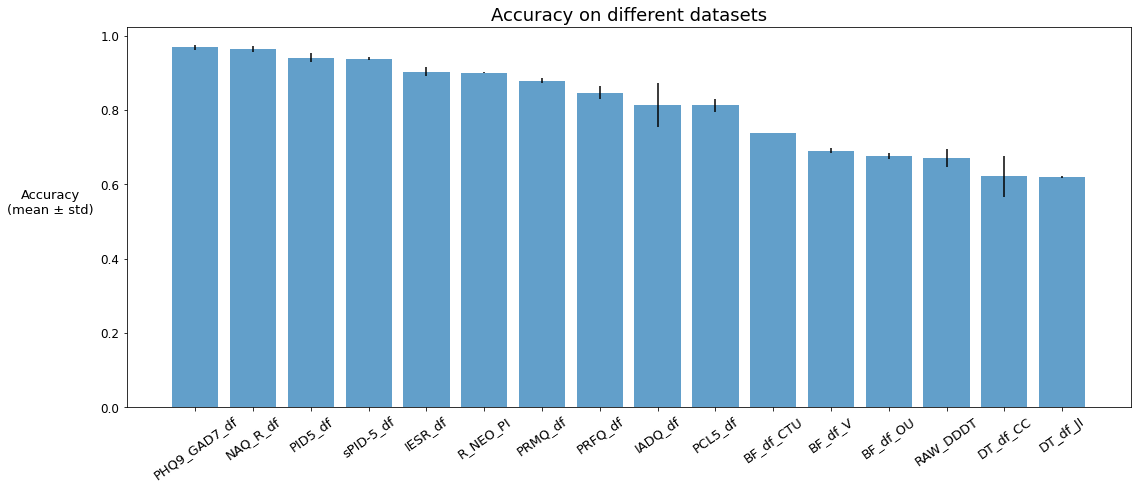

In [26]:
summary_graphs.accuracy_barplot(pca_summary, save = True, prefix = "PCA")

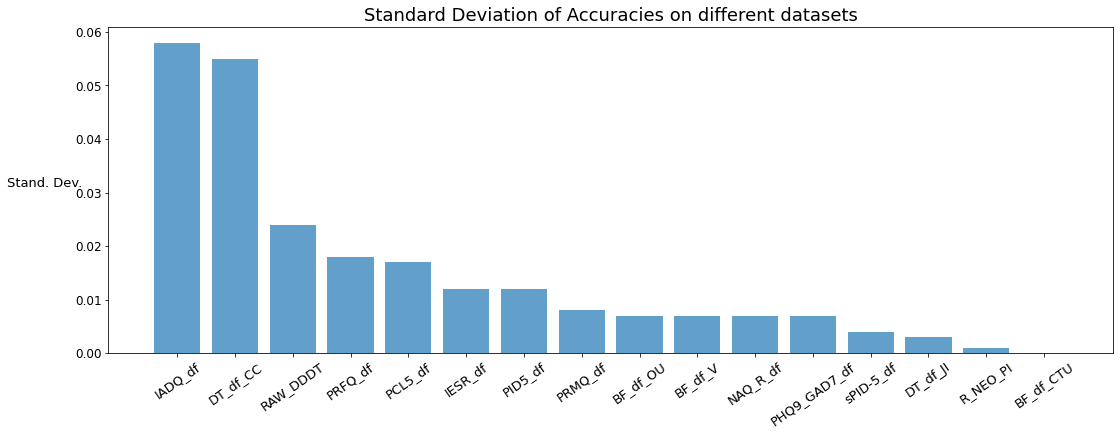

In [24]:
summary_graphs.accuracy_std(pca_summary, save = True, prefix = "PCA")

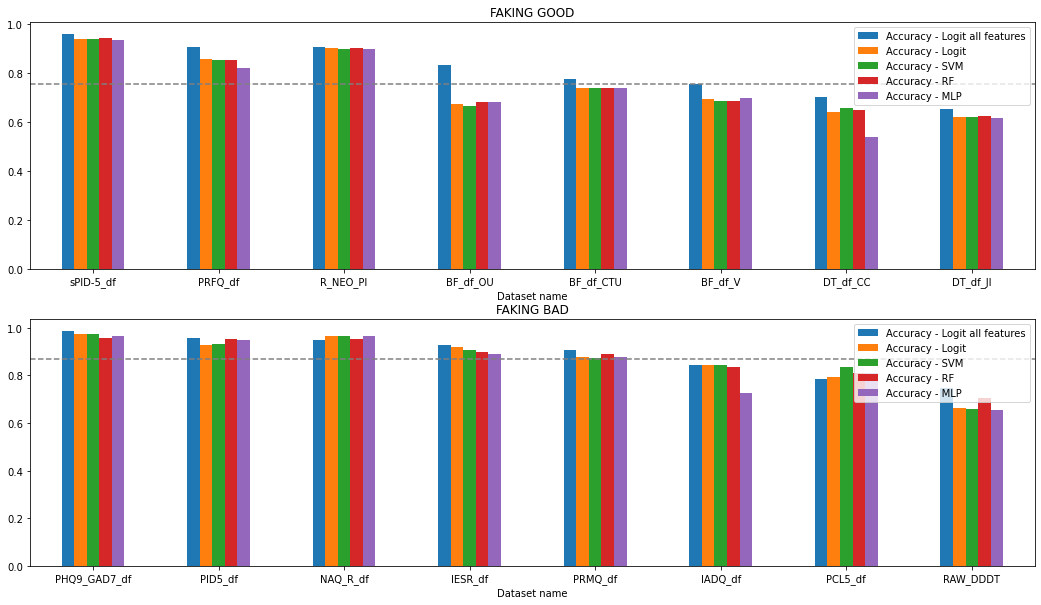

In [25]:
summary_graphs.faking_type_comparison(pca_summary, prefix = "PCA", save = True)

## Permutation Importance
***

The goal is to find a stable subset of features across datasets that performs roughly the same across different classifiers. Accoringly, we can define a "good" feature selection procedure, one that does not depend on a specific model, but that allows models to perform roughly the same, and for all the datasets within the scope.

##### DESCRIPTION
1. A given dataset is split in training and test. For every feature, the mean and the standard deviation are computed in order to scale that feauture: $Z=\frac{X-\mu}{\sigma}$. Scaling on the test set is carried out using the same values computed for training data.
2. The actual phase of the selection of a subset of features occurs through a 3-step process:  
    * Train a Decision Tree and apply minimal cost-complexity pruning. <sup>[1]</sup>  
    * Train a Random Forest that expolits gradient boosting <sup>[2]</sup>, in which each tree retains the cost-complexity parameter obtained in the previous step.  
    * Compute permutation importance on this Random Forest <sup>[3]</sup>.  
    * Perform a one-sample test on the mean, given the distribution obtained for each feature importance (with confidence level at 99.999%). This way only features whose importance is significantly greater than zero are retained, all the others are discarded. We call this subset of feature $A^*$  
    * Perform a Wilks test <sup>[4]</sup> comparing two logistic regressions, one fitted with the full set of features, the other with $A^*$. By accepting the null hypothesis of the test (at 95% confidence level), the assertion "the ration  between the likelihoods of the two (nested) models is one".  
    * Train an arbitrary amount of different models in order to assess the quality of the feature selection procedure. If all models show very close accuracy, then the procedure proves to provide a model-indifferent subset $A^*$ of features.


##### SOURCES
* [How can I get statistics to compare nested models in a logistic regression in SPSS?](https://www.ibm.com/support/pages/how-can-i-get-statistics-compare-nested-models-logistic-regression-spss)
* [Likelihood-ratio test](https://en.wikipedia.org/wiki/Likelihood-ratio_test)

##### SUPPORTING PAPERS
[1] L. Breiman, J. Friedman, R. Olshen, and C. Stone. *Classification and Regression Trees*. Wadsworth, Belmont, CA, 1984.  
[2] J. Friedman, Greedy Function Approximation: *A Gradient Boosting Machine*, The Annals of Statistics, Vol. 29, No. 5, 2001  
[3] Leo Breiman. Random forests. *Machine learning*, 45(1):5-32, 2001.  
[4] Li, Bing; Babu, G. Jogesh (2019). *A Graduate Course on Statistical Inference*. Springer. p. 331

In [8]:
### PIPELINE
# Organize datasets
data_collection = {}
for dataset in [f for f in os.listdir(data_dir) if "parquet" in f]:
    print(dataset.split(".")[0])
    X_tr, X_ts, y_tr, y_ts = Classification().prepare_data(f"{data_dir}\\{dataset}", "CONDITION")
    var_sel = Classification().variable_selection(X_tr, X_ts, y_tr, y_ts)
    perfs, stability = Classification().benchmark_models(X_tr, X_ts, y_tr, y_ts, var_sel)
    data_collection[dataset.split(".")[0]] = [X_tr, X_ts, y_tr, y_ts, var_sel, perfs, stability]
    print(var_sel)
    print(perfs)
    print()
    print("==> TOP5 STABILITY SCORE: {}".format(stability))
    print("-" * 100)
    print("-" * 100)
    print("-" * 100)
    print()

BF_df_CTU


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 309
Selected 4 features out of 10
{'Features': [2, 4, 6, 7], 'Wilks test p-value': 0.9893064, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3  FI 4
Full Logit           0.774436   NaN   NaN   NaN   NaN
Logistic Regression  0.812030   6.0   2.0   4.0   7.0
SVC                  0.812030   6.0   2.0   4.0   7.0
Random Forest        0.827068   6.0   7.0   2.0   4.0
Neural Network       0.827068   4.0   6.0   7.0   2.0

==> TOP5 STABILITY SCORE: 0.417
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

BF_df_OU


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 322
Selected 3 features out of 10
{'Features': [4, 6, 7], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3
Full Logit           0.833333   NaN   NaN   NaN
Logistic Regression  0.811594   6.0   4.0   7.0
SVC                  0.797101   6.0   4.0   7.0
Random Forest        0.782609   6.0   4.0   7.0
Neural Network       0.818841   6.0   7.0   4.0

==> TOP5 STABILITY SCORE: 0.778
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

BF_df_V


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 340
Selected 1 features out of 10
{'Features': [7], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1
Full Logit           0.760274   NaN
Logistic Regression  0.684932   7.0
SVC                  0.684932   7.0
Random Forest        0.684932   7.0
Neural Network       0.684932   7.0

==> TOP5 STABILITY SCORE: 1.0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

DT_df_CC


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 998us/step
Train size: 337
Selected 3 features out of 27
{'Features': [9, 10, 13], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3
Full Logit           0.682759   NaN   NaN   NaN
Logistic Regression  0.731034  13.0  10.0   9.0
SVC                  0.731034  13.0  10.0   9.0
Random Forest        0.710345  13.0  10.0   9.0
Neural Network       0.731034  13.0   9.0  10.0

==> TOP5 STABILITY SCORE: 0.778
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

DT_df_JI


  0%|          | 0/100 [00:00<?, ?it/s]

9/9 [==============================] - 0s 873us/step
Train size: 604
Selected 5 features out of 27
{'Features': [2, 3, 6, 15, 18], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.661538   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.653846   2.0  18.0   6.0  15.0   3.0
SVC                  0.661538   2.0  18.0   6.0  15.0   3.0
Random Forest        0.607692  18.0  15.0   6.0   2.0   3.0
Neural Network       0.657692  18.0   6.0   2.0  15.0   3.0

==> TOP5 STABILITY SCORE: 0.667
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

IADQ_df


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 2ms/step
Train size: 315
Selected 2 features out of 9
{'Features': [4, 6], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2
Full Logit           0.851852   NaN   NaN
Logistic Regression  0.829630   6.0   4.0
SVC                  0.829630   6.0   4.0
Random Forest        0.814815   4.0   6.0
Neural Network       0.822222   4.0   6.0

==> TOP5 STABILITY SCORE: 0.667
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

IESR_df


  0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step
Train size: 250
Selected 4 features out of 22
{'Features': [8, 13, 18, 19], 'Wilks test p-value': 1.0, 'High correlation': True}
                     Accuracy  FI 1  FI 2  FI 3  FI 4
Full Logit           0.935185   NaN   NaN   NaN   NaN
Logistic Regression  0.888889   8.0  18.0  19.0  13.0
SVC                  0.907407   8.0  18.0  19.0  13.0
Random Forest        0.907407  18.0  13.0   8.0  19.0
Neural Network       0.916667  13.0  18.0   8.0  19.0

==> TOP5 STABILITY SCORE: 0.583
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

NAQ_R_df


  0%|          | 0/100 [00:00<?, ?it/s]

7/7 [==============================] - 0s 1ms/step
Train size: 498
Selected 1 features out of 22
{'Features': [9], 'Wilks test p-value': 1.0, 'High correlation': True}
                     Accuracy  FI 1
Full Logit           0.953271   NaN
Logistic Regression  0.929907   9.0
SVC                  0.929907   9.0
Random Forest        0.929907   9.0
Neural Network       0.929907   9.0

==> TOP5 STABILITY SCORE: 1.0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PCL5_df


  0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step
Train size: 281
Selected 2 features out of 20
{'Features': [1, 4], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2
Full Logit           0.809917   NaN   NaN
Logistic Regression  0.826446   4.0   1.0
SVC                  0.826446   4.0   1.0
Random Forest        0.818182   1.0   4.0
Neural Network       0.826446   4.0   1.0

==> TOP5 STABILITY SCORE: 0.667
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PHQ9_GAD7_df


  0%|          | 0/100 [00:00<?, ?it/s]

11/11 [==============================] - 0s 898us/step
Train size: 782
Selected 4 features out of 16
{'Features': [0, 1, 6, 7], 'Wilks test p-value': 1.0, 'High correlation': True}
                     Accuracy  FI 1  FI 2  FI 3  FI 4
Full Logit           0.991071   NaN   NaN   NaN   NaN
Logistic Regression  0.982143   7.0   1.0   6.0   0.0
SVC                  0.982143   7.0   1.0   6.0   0.0
Random Forest        0.973214   7.0   1.0   6.0   0.0
Neural Network       0.979167   7.0   1.0   6.0   0.0

==> TOP5 STABILITY SCORE: 1.0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PID5_df


  0%|          | 0/100 [00:00<?, ?it/s]

8/8 [==============================] - 0s 966us/step
Train size: 576
Selected 3 features out of 220
{'Features': [1, 53, 191], 'Wilks test p-value': 1.0, 'High correlation': True}
                     Accuracy  FI 1   FI 2   FI 3
Full Logit           0.959677   NaN    NaN    NaN
Logistic Regression  0.927419   1.0  191.0   53.0
SVC                  0.927419   1.0  191.0   53.0
Random Forest        0.923387   1.0  191.0   53.0
Neural Network       0.931452   1.0   53.0  191.0

==> TOP5 STABILITY SCORE: 0.778
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PRFQ_df


  0%|          | 0/100 [00:00<?, ?it/s]

7/7 [==============================] - 0s 1ms/step
Train size: 474
Selected 4 features out of 18
{'Features': [6, 7, 8, 11], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3  FI 4
Full Logit           0.936275   NaN   NaN   NaN   NaN
Logistic Regression  0.892157  11.0   6.0   7.0   8.0
SVC                  0.892157  11.0   6.0   7.0   8.0
Random Forest        0.916667   6.0  11.0   7.0   8.0
Neural Network       0.897059  11.0   8.0   7.0   6.0

==> TOP5 STABILITY SCORE: 0.667
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PRMQ_df


  0%|          | 0/100 [00:00<?, ?it/s]

14/14 [==============================] - 0s 876us/step
Train size: 982
Selected 5 features out of 16
{'Features': [1, 4, 7, 12, 14], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.907583   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.890995   1.0  12.0   7.0   4.0  14.0
SVC                  0.890995   1.0  12.0   7.0   4.0  14.0
Random Forest        0.888626   1.0   7.0  12.0   4.0  14.0
Neural Network       0.895735   1.0   7.0  12.0   4.0  14.0

==> TOP5 STABILITY SCORE: 0.867
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

RAW_DDDT


  0%|          | 0/100 [00:00<?, ?it/s]

10/10 [==============================] - 0s 884us/step
Train size: 690
Selected 4 features out of 12
{'Features': [0, 1, 9, 10], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3  FI 4
Full Logit           0.746622   NaN   NaN   NaN   NaN
Logistic Regression  0.746622   1.0  10.0   9.0   0.0
SVC                  0.743243   1.0  10.0   9.0   0.0
Random Forest        0.760135  10.0   1.0   0.0   9.0
Neural Network       0.743243   1.0  10.0   0.0   9.0

==> TOP5 STABILITY SCORE: 0.667
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

R_NEO_PI


  0%|          | 0/100 [00:00<?, ?it/s]

729/729 [==============================] - 1s 1ms/step
Train size: 54380
Selected 19 features out of 30
{'Features': [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 18, 21, 22, 26, 27, 29], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.906938   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.907109  21.0  13.0   5.0  29.0  11.0
SVC                  0.905565  21.0  13.0   5.0  29.0  14.0
Random Forest        0.911185  21.0  29.0  13.0   5.0  22.0
Neural Network       0.914189  21.0   5.0  13.0  29.0   1.0

==> TOP5 STABILITY SCORE: 0.533
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

sPID-5_df


  0%|          | 0/100 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
Train size: 726
Selected 7 features out of 25
{'Features': [2, 4, 11, 14, 16, 20, 23], 'Wilks test p-value': 1.0, 'High correlation': True}
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.961538   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.971154  23.0  14.0  11.0   4.0  16.0
SVC                  0.971154  23.0  14.0   4.0  11.0  16.0
Random Forest        0.958333  23.0  20.0   4.0  14.0  16.0
Neural Network       0.967949  23.0   4.0  11.0  20.0   2.0

==> TOP5 STABILITY SCORE: 0.533
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



## Assess quality of analysis
***

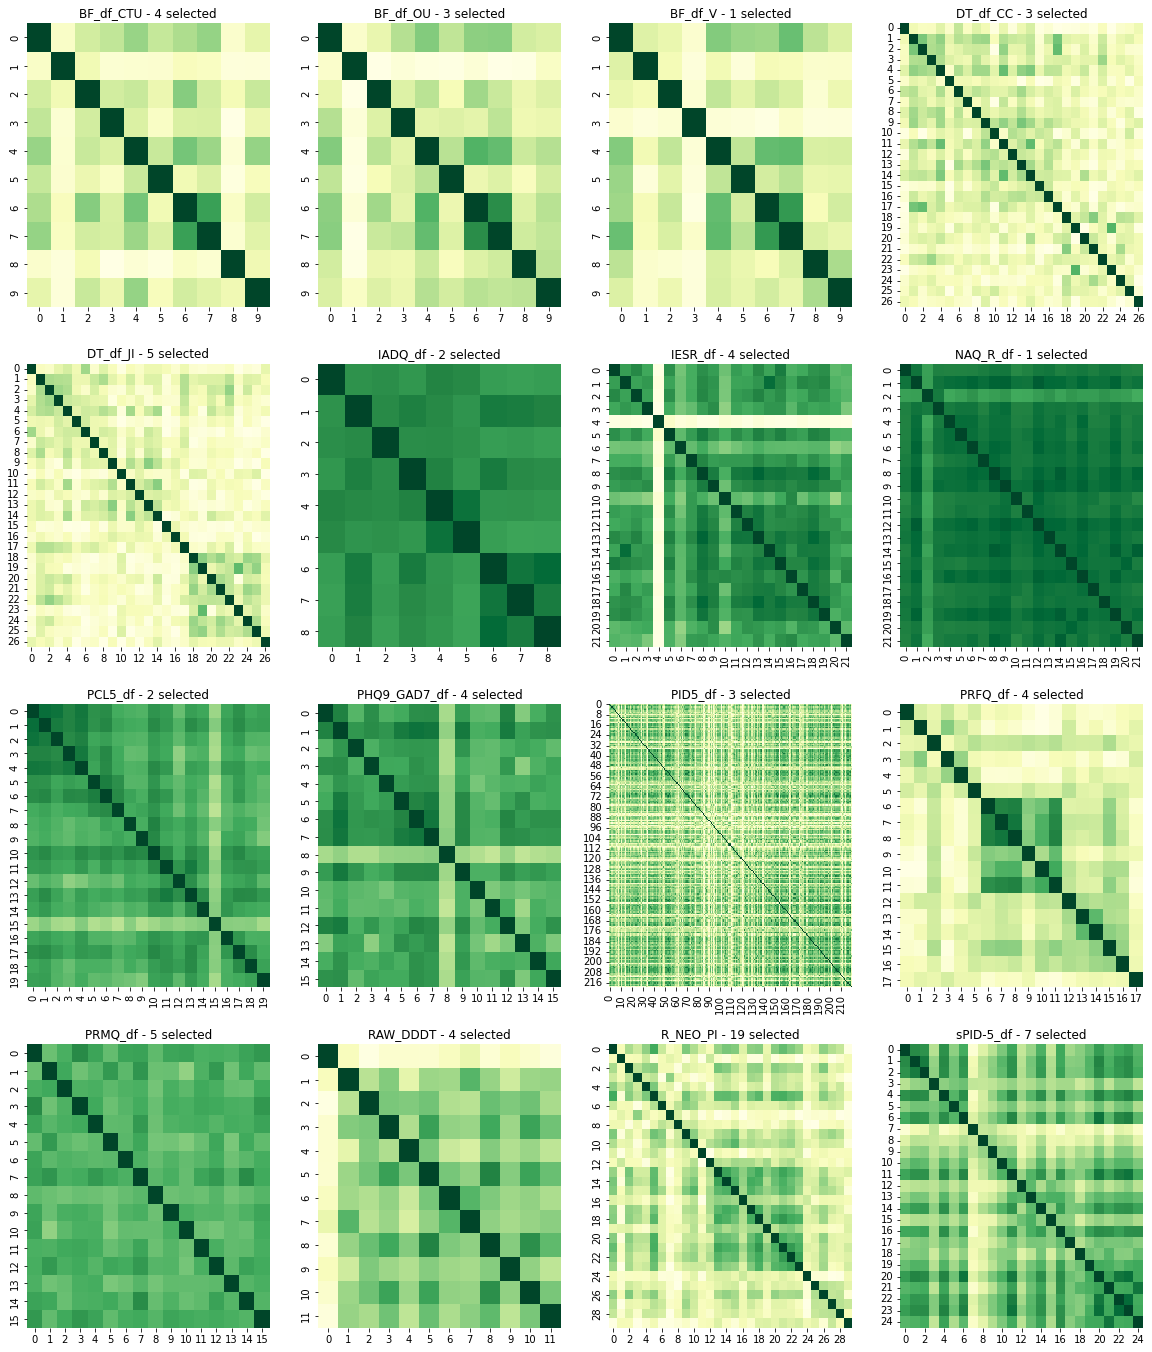

In [9]:
# Compare with correlation matrices
# The greener the higher the correlation
f0, ax0 = plt.subplots(4, 4, figsize = (20, 24))
for n, k in enumerate(data_collection.keys()):
    
    sns.heatmap(pd.DataFrame(data_collection[k][0]).corr().abs(),
                vmin = 0, vmax = 1, cmap = "YlGn",
                cbar = False, ax = ax0[n//4, n%4])
    ax0[n//4, n%4].set_title("{} - {} selected"\
                             .format(k, len(data_collection[k][-3]["Features"])))
plt.show()

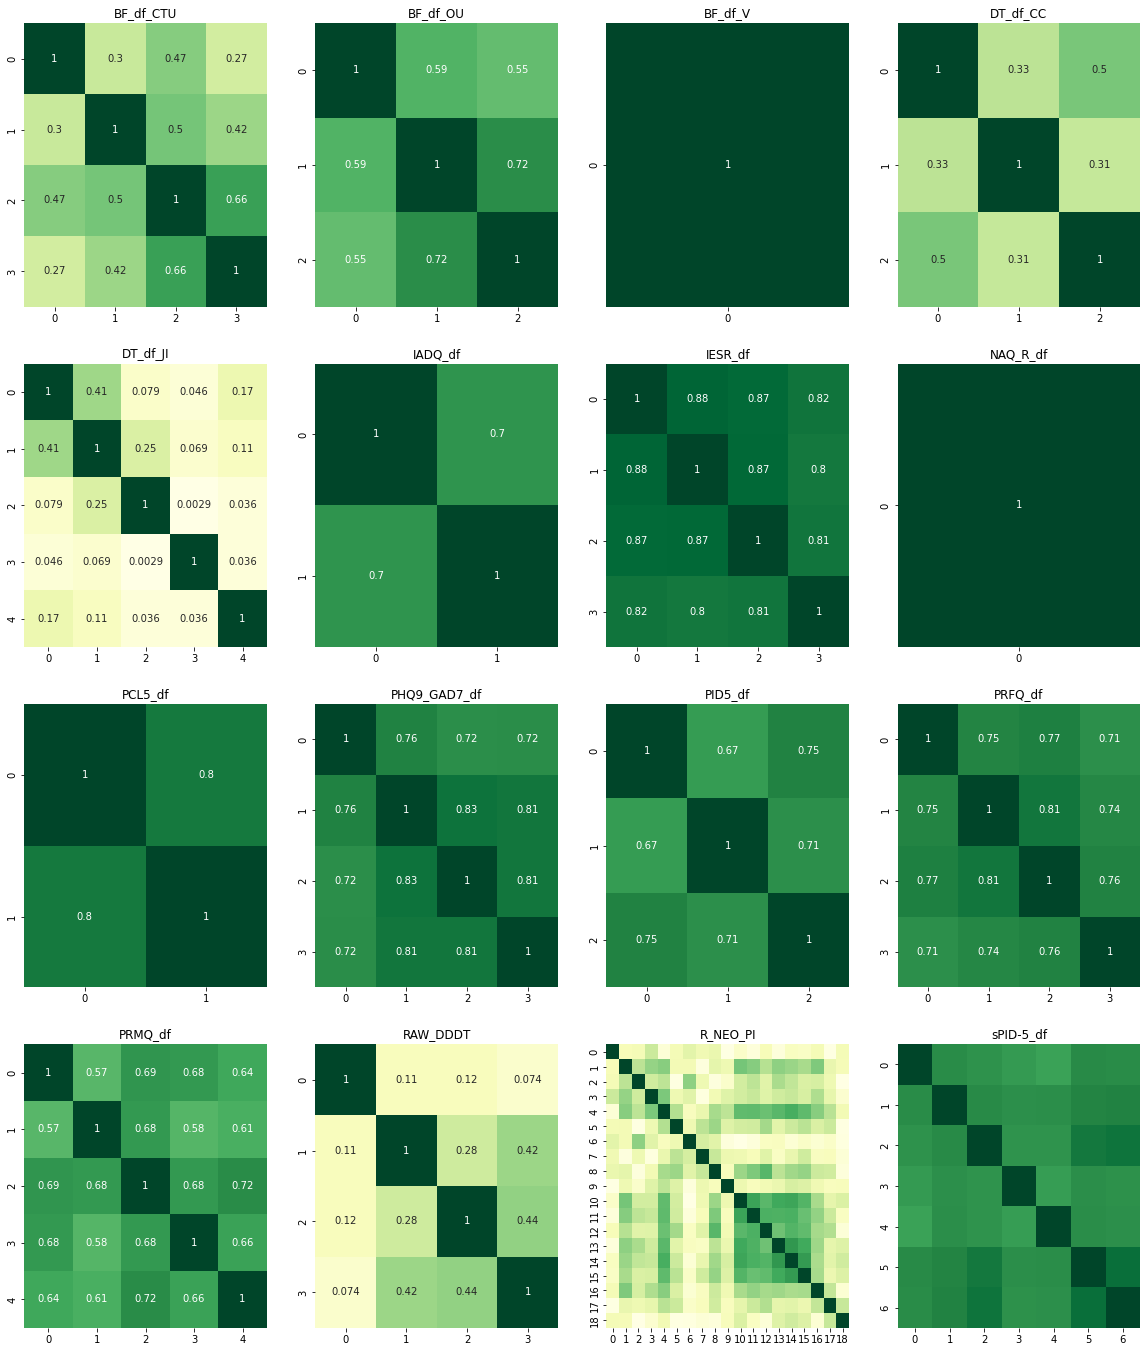

In [10]:
# Correlation matrices of only selected features
# The greener the higher the correlation
f1, ax1 = plt.subplots(4, 4, figsize = (20, 24))
for n, k in enumerate(data_collection.keys()):
    
    feats = data_collection[k][-3]["Features"]
    
    annotation = True if len(feats) < 7 else False
    
    sns.heatmap(pd.DataFrame(data_collection[k][0][:,feats]).corr().abs(),
                vmin = 0, vmax = 1, cmap = "YlGn", annot = annotation,
                cbar = False, ax = ax1[n//4, n%4])

    ax1[n//4, n%4].set_title(k)
    
plt.show()

In [11]:
benchmark = evaluation.lasso_benchmark(data_collection)

benchmark_df = pd.DataFrame(benchmark,
                            columns = ["Dataset", "Algo", "λ min", "λ 1se",
                                       "Zero coeffs at λ min",
                                       "Delta accuracy"]).drop("Algo", axis = 1)

benchmark_df["Delta accuracy"] = benchmark_df["Delta accuracy"].apply(lambda s: s.loc["Accuracy"])
benchmark_df

,Dataset,λ min,λ 1se,Zero coeffs at λ min,Delta accuracy
0,BF_df_CTU,0.100,0.100,0,0.000
1,BF_df_OU,0.100,0.100,0,-0.007
2,BF_df_V,0.100,0.100,0,0.000
3,DT_df_CC,0.100,0.100,0,0.000
4,DT_df_JI,0.768,4.109,0,0.000
5,IADQ_df,0.100,0.100,0,0.000
6,IESR_df,1.436,0.100,0,0.009
7,NAQ_R_df,1.436,0.100,0,0.000
8,PCL5_df,0.100,22.820,0,0.000
9,PHQ9_GAD7_df,25.159,23.154,0,0.000


In [12]:
#evaluation.graphical_lasso_benchmark(benchmark[7])

## Summarize results
***

In [13]:
pimp_summary = evaluation.summary_table(data_collection, stability = True, neural_net = True)
pimp_summary

,Dataset name,Sample size,Training size,Number of Features,Selected Features,Feat. Top5-Stability,Accuracy - Logit all features,Accuracy - Logit,Accuracy - SVM,Accuracy - RF,Accuracy - MLP,Avg Acc. on selected features,Accuracy Std on selected features,Acc. diff. wrt Full logit
0,BF_df_CTU,442,309,10,4,0.417,0.774,0.812,0.812,0.827,0.827,0.820,0.009,0.045
1,BF_df_OU,460,322,10,3,0.778,0.833,0.812,0.797,0.783,0.819,0.803,0.016,-0.031
2,BF_df_V,486,340,10,1,1.000,0.760,0.685,0.685,0.685,0.685,0.685,0.000,-0.075
3,DT_df_CC,482,337,27,3,0.778,0.683,0.731,0.731,0.710,0.731,0.726,0.010,0.043
4,DT_df_JI,864,604,27,5,0.667,0.662,0.654,0.662,0.608,0.658,0.645,0.025,-0.016
5,IADQ_df,450,315,9,2,0.667,0.852,0.830,0.830,0.815,0.822,0.824,0.007,-0.028
6,IESR_df,358,250,22,4,0.583,0.935,0.889,0.907,0.907,0.917,0.905,0.012,-0.030
7,NAQ_R_df,712,498,22,1,1.000,0.953,0.930,0.930,0.930,0.930,0.930,0.000,-0.023
8,PCL5_df,402,281,20,2,0.667,0.810,0.826,0.826,0.818,0.826,0.824,0.004,0.014
9,PHQ9_GAD7_df,1118,782,16,4,1.000,0.991,0.982,0.982,0.973,0.979,0.979,0.004,-0.012


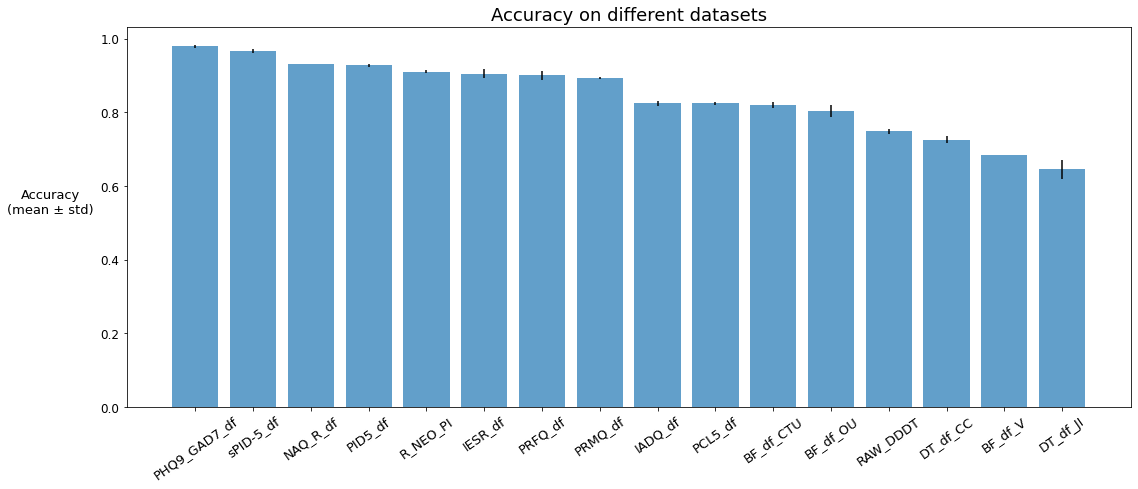

In [27]:
summary_graphs.accuracy_barplot(pimp_summary, save = True, prefix = "PERMIMP")

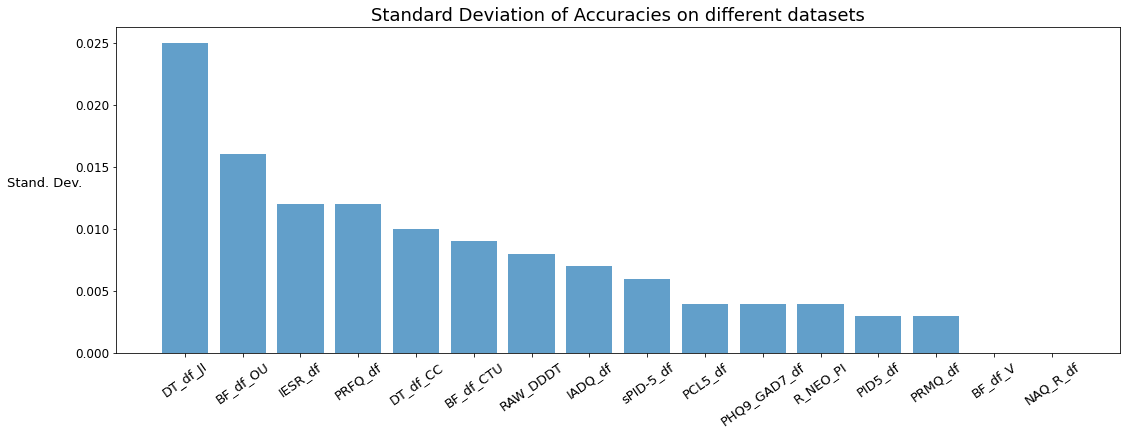

In [28]:
summary_graphs.accuracy_std(pimp_summary, save = True, prefix = "PERMIMP")

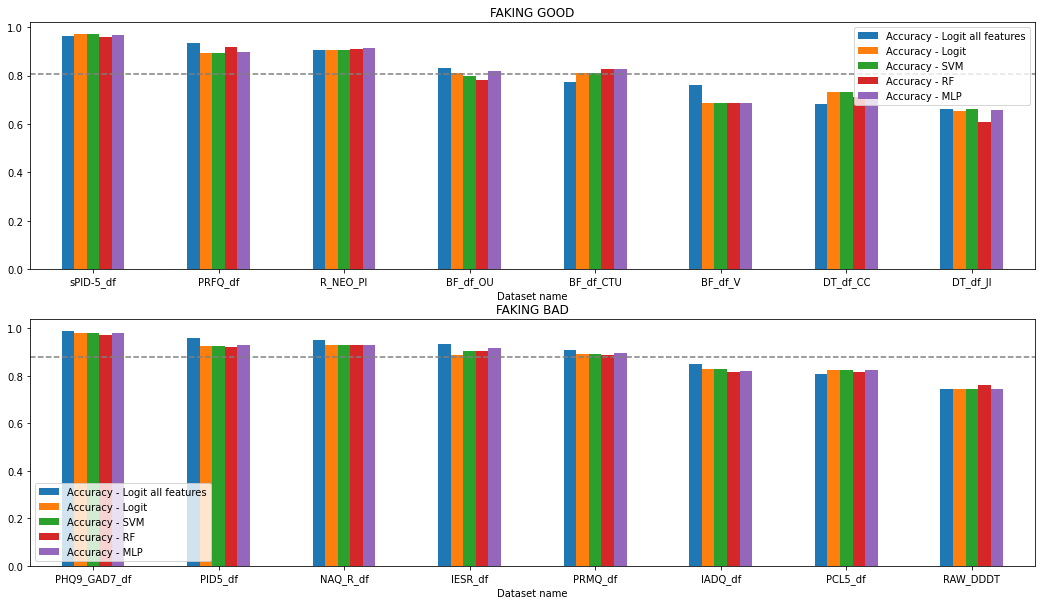

In [29]:
summary_graphs.faking_type_comparison(pimp_summary, prefix = "PERMIMP", save = True)

---
---
---

## Mutual Information (JMIM)

Joint Mutual Information Maximization (JMIM) is a greedy algorithm used to select the best subset of features to predict a response variable. The way the algorithm works is based on information theory and especially mutual information. Mutual information can be expressed as the amount of information provided by variable X, which reduces the uncertainty of variable Y.MI is zero if the random variables are statistically independent.
MI does not make an assumption of linearity between the variables, and can deal with categorical and numerical data with two or more class values. In this algorithm we especially deal with joint mutual information which is simply the mutual information between a set of variables and another single variable. In this case the set of variables will represent the already chosen features and the other variable will be the response variable. The way the algorithm proceeds so is the following:
1) The first feature is simply chosen by taking the feature which maximizes the MI with the response variable. <br>
2) From now on every other feature will be chosen baseed on the JMIM criteria, so we will choose feature that maximizes the MI between the set of already chosen features (plus itself) and the response variable. <br>
3) We repeat this procedure until the desired number of features is reached. <br>

The advantage of this algortihm over all the others MI-based competitors is that for the MI maximization it takes into account every single possible new feature with the already chosen features, in this way we will avoid to choose redundant features unlike in other methods such as Conditional Mutual Information Maximization (CMIM) where we maximize simply the mutual information between the remaining features and the response variable.

In this specific case the algorithm is run in order to return a subset of features that consists in all of the features of the dataset. This is done in order to have a "score" of how much information choosing a specific variable has added to the model. If we look at the trend across datasets we can see that as we add features to the "predictors" set we have a declining level of added information (e.g the features don't add much value and we risk overfitting). 
So what is practically done is that we run the algorithm until the features selected add a value of at least 0.8 (scores go from 0 to 1) and after that we stop and use the set, up that point, of selected features as the predictors variables. 

##### SUPPORTING PAPERS
[1] A. Kraskov, H. Stogbauer and P. Grassberger, “Estimating mutual information”. Phys. Rev. E 69, 2004.  
[2] B. C. Ross “Mutual Information between Discrete and Continuous Data Sets”. PLoS ONE 9(2), 2014.  
[3] L. F. Kozachenko, N. N. Leonenko, “Sample Estimate of the Entropy of a Random Vector:, Probl. Peredachi Inf., 23:2 (1987), 9-16

In [17]:
# Organize datasets
mis_datasets = {}

for dataset in [f for f in os.listdir(".\\data") if "parquet" in f]:
    print(dataset.split(".")[0])
    X_tr, X_ts, y_tr, y_ts = Classification().prepare_data(f".\\data\\{dataset}", "CONDITION")
    
    var_sel = Classification().mutual_info(X_tr, y_tr)
    perfs, stability = Classification().benchmark_models(X_tr, X_ts, y_tr, y_ts, var_sel)
    
    mis_datasets[dataset.split(".")[0]] = [X_tr, X_ts, y_tr, y_ts, var_sel, perfs, stability]
    print(var_sel)
    print(perfs)
    print()
    print("==> TOP5 STABILITY SCORE: {}".format(stability))
    print("-" * 100)
    print("-" * 100)
    print("-" * 100)
    print()

BF_df_CTU


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 309
Selected 3 features out of 10
[4 7 2]
                     Accuracy  FI 1  FI 2  FI 3
Full Logit           0.774436   NaN   NaN   NaN
Logistic Regression  0.819549   7.0   2.0   4.0
SVC                  0.819549   7.0   2.0   4.0
Random Forest        0.804511   7.0   4.0   2.0
Neural Network       0.842105   7.0   4.0   2.0

==> TOP5 STABILITY SCORE: 0.778
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

BF_df_OU


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 322
Selected 2 features out of 10
[0 7]
                     Accuracy  FI 1  FI 2
Full Logit           0.833333   NaN   NaN
Logistic Regression  0.746377   7.0   0.0
SVC                  0.753623   7.0   0.0
Random Forest        0.768116   7.0   0.0
Neural Network       0.760870   7.0   0.0

==> TOP5 STABILITY SCORE: 1.0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

BF_df_V


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 340
Selected 3 features out of 10
[4 0 6]
                     Accuracy  FI 1  FI 2  FI 3
Full Logit           0.760274   NaN   NaN   NaN
Logistic Regression  0.760274   6.0   0.0   4.0
SVC                  0.760274   6.0   0.0   4.0
Random Forest        0.760274   6.0   4.0   0.0
Neural Network       0.760274   4.0   0.0   6.0

==> TOP5 STABILITY SCORE: 0.556
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

DT_df_CC


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 337
Selected 2 features out of 27
[10  6]
                     Accuracy  FI 1  FI 2
Full Logit           0.682759   NaN   NaN
Logistic Regression  0.689655  10.0   6.0
SVC                  0.689655  10.0   6.0
Random Forest        0.689655  10.0   6.0
Neural Network       0.689655   6.0  10.0

==> TOP5 STABILITY SCORE: 0.667
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

DT_df_JI


  0%|          | 0/100 [00:00<?, ?it/s]

9/9 [==============================] - 0s 1ms/step
Train size: 604
Selected 2 features out of 27
[2 6]
                     Accuracy  FI 1  FI 2
Full Logit           0.661538   NaN   NaN
Logistic Regression  0.642308   2.0   6.0
SVC                  0.642308   2.0   6.0
Random Forest        0.623077   2.0   6.0
Neural Network       0.642308   2.0   6.0

==> TOP5 STABILITY SCORE: 1.0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

IADQ_df


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 2ms/step
Train size: 315
Selected 6 features out of 9
[1 4 8 2 6 3]
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.851852   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.844444   3.0   1.0   4.0   8.0   6.0
SVC                  0.844444   3.0   1.0   8.0   4.0   2.0
Random Forest        0.829630   8.0   4.0   3.0   1.0   6.0
Neural Network       0.829630   8.0   2.0   6.0   1.0   4.0

==> TOP5 STABILITY SCORE: 0.333
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

IESR_df


  0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step
Train size: 250
Selected 11 features out of 22
[17  8 18 15 16 19 11 14 13  7  5]
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.935185   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.907407   8.0  18.0  19.0  13.0  14.0
SVC                  0.888889   8.0  18.0  19.0  13.0  14.0
Random Forest        0.898148   8.0  13.0   7.0  19.0  17.0
Neural Network       0.925926  13.0  14.0  18.0   7.0  11.0

==> TOP5 STABILITY SCORE: 0.4
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

NAQ_R_df


  0%|          | 0/100 [00:00<?, ?it/s]

7/7 [==============================] - 0s 1ms/step
Train size: 498
Selected 21 features out of 22
[ 1 15 12  5 16 10 17 19  8  6 13 21  9  7 18 11  3 14  4  0 20]
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.953271   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.971963   9.0  21.0  12.0   8.0   5.0
SVC                  0.962617   9.0  21.0   5.0  12.0   3.0
Random Forest        0.962617  21.0  15.0  11.0   6.0   3.0
Neural Network       0.962617  19.0  10.0  12.0  13.0   8.0

==> TOP5 STABILITY SCORE: 0.267
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PCL5_df


  0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 0s 889us/step
Train size: 281
Selected 5 features out of 20
[18  1 13  2 10]
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.809917   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.768595   1.0  13.0   2.0  10.0  18.0
SVC                  0.776860   1.0  13.0  10.0   2.0  18.0
Random Forest        0.760331  13.0   1.0   2.0  10.0  18.0
Neural Network       0.834711   2.0  13.0   1.0  10.0  18.0

==> TOP5 STABILITY SCORE: 0.6
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PHQ9_GAD7_df


  0%|          | 0/100 [00:00<?, ?it/s]

11/11 [==============================] - 0s 852us/step
Train size: 782
Selected 7 features out of 16
[ 1  6  9  0  5  7 12]
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.991071   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.982143   7.0   6.0   1.0   9.0   5.0
SVC                  0.982143   7.0   1.0   6.0   0.0   9.0
Random Forest        0.973214   7.0   1.0  12.0   6.0   0.0
Neural Network       0.982143   7.0   6.0   5.0   1.0   9.0

==> TOP5 STABILITY SCORE: 0.4
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PID5_df


  0%|          | 0/100 [00:00<?, ?it/s]

8/8 [==============================] - 0s 1ms/step
Train size: 576
Selected 13 features out of 220
[165 132 191 171 151  57 138   1 189 177 216 135  35]
                     Accuracy   FI 1   FI 2   FI 3   FI 4   FI 5
Full Logit           0.959677    NaN    NaN    NaN    NaN    NaN
Logistic Regression  0.955645    1.0  165.0  191.0  177.0   57.0
SVC                  0.955645    1.0  165.0  191.0  177.0  171.0
Random Forest        0.947581    1.0  165.0  132.0   57.0  171.0
Neural Network       0.947581  165.0  135.0    1.0  171.0  132.0

==> TOP5 STABILITY SCORE: 0.467
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PRFQ_df


  0%|          | 0/100 [00:00<?, ?it/s]

7/7 [==============================] - 0s 991us/step
Train size: 474
Selected 4 features out of 18
[6 2 8 7]
                     Accuracy  FI 1  FI 2  FI 3  FI 4
Full Logit           0.936275   NaN   NaN   NaN   NaN
Logistic Regression  0.877451   6.0   7.0   8.0   2.0
SVC                  0.877451   6.0   7.0   8.0   2.0
Random Forest        0.872549   6.0   2.0   8.0   7.0
Neural Network       0.911765   7.0   8.0   6.0   2.0

==> TOP5 STABILITY SCORE: 0.583
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PRMQ_df


  0%|          | 0/100 [00:00<?, ?it/s]

14/14 [==============================] - 0s 805us/step
Train size: 982
Selected 5 features out of 16
[ 7 12  4 14 15]
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.907583   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.864929  12.0   7.0   4.0  14.0  15.0
SVC                  0.862559  12.0   7.0   4.0  14.0  15.0
Random Forest        0.864929  12.0   7.0   4.0  14.0  15.0
Neural Network       0.879147   7.0  12.0  14.0   4.0  15.0

==> TOP5 STABILITY SCORE: 0.733
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

RAW_DDDT


  0%|          | 0/100 [00:00<?, ?it/s]

10/10 [==============================] - 0s 1ms/step
Train size: 690
Selected 3 features out of 12
[10  0  7]
                     Accuracy  FI 1  FI 2  FI 3
Full Logit           0.746622   NaN   NaN   NaN
Logistic Regression  0.736486   7.0  10.0   0.0
SVC                  0.746622   7.0  10.0   0.0
Random Forest        0.756757  10.0   7.0   0.0
Neural Network       0.739865  10.0   0.0   7.0

==> TOP5 STABILITY SCORE: 0.556
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

R_NEO_PI


  0%|          | 0/100 [00:00<?, ?it/s]

729/729 [==============================] - 1s 795us/step
Train size: 54380
Selected 6 features out of 30
[13 29 22  5 21 14]
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.906938   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.902433  13.0  29.0  21.0   5.0  22.0
SVC                  0.900888  13.0  21.0  29.0   5.0  22.0
Random Forest        0.906294  29.0  13.0   5.0  21.0  22.0
Neural Network       0.904964  29.0  13.0  22.0   5.0  21.0

==> TOP5 STABILITY SCORE: 0.467
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

sPID-5_df


  0%|          | 0/100 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
Train size: 726
Selected 10 features out of 25
[14 20 11  1 22  4 23 16  6  2]
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.961538   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.967949  23.0  14.0   4.0  11.0  16.0
SVC                  0.971154  23.0  14.0  16.0   4.0  11.0
Random Forest        0.964744  23.0  20.0   4.0  16.0  11.0
Neural Network       0.971154  23.0  16.0  14.0  20.0   4.0

==> TOP5 STABILITY SCORE: 0.4
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



### Analysis of results

In [18]:
mis_summary = evaluation.summary_table(mis_datasets, stability = True, neural_net = True)
mis_summary.sort_values("Accuracy Std on selected features", ascending = False)

,Dataset name,Sample size,Training size,Number of Features,Selected Features,Feat. Top5-Stability,Accuracy - Logit all features,Accuracy - Logit,Accuracy - SVM,Accuracy - RF,Accuracy - MLP,Avg Acc. on selected features,Accuracy Std on selected features,Acc. diff. wrt Full logit
8,PCL5_df,402,281,20,5,0.600,0.810,0.769,0.777,0.760,0.835,0.785,0.034,-0.025
11,PRFQ_df,678,474,18,4,0.583,0.936,0.877,0.877,0.873,0.912,0.885,0.018,-0.051
0,BF_df_CTU,442,309,10,3,0.778,0.774,0.820,0.820,0.805,0.842,0.821,0.016,0.047
6,IESR_df,358,250,22,11,0.400,0.935,0.907,0.889,0.898,0.926,0.905,0.016,-0.030
4,DT_df_JI,864,604,27,2,1.000,0.662,0.642,0.642,0.623,0.642,0.638,0.010,-0.024
1,BF_df_OU,460,322,10,2,1.000,0.833,0.746,0.754,0.768,0.761,0.757,0.009,-0.076
5,IADQ_df,450,315,9,6,0.333,0.852,0.844,0.844,0.830,0.830,0.837,0.009,-0.015
13,RAW_DDDT,986,690,12,3,0.556,0.747,0.736,0.747,0.757,0.740,0.745,0.009,-0.002
12,PRMQ_df,1404,982,16,5,0.733,0.908,0.865,0.863,0.865,0.879,0.868,0.008,-0.040
7,NAQ_R_df,712,498,22,21,0.267,0.953,0.972,0.963,0.963,0.963,0.965,0.005,0.012


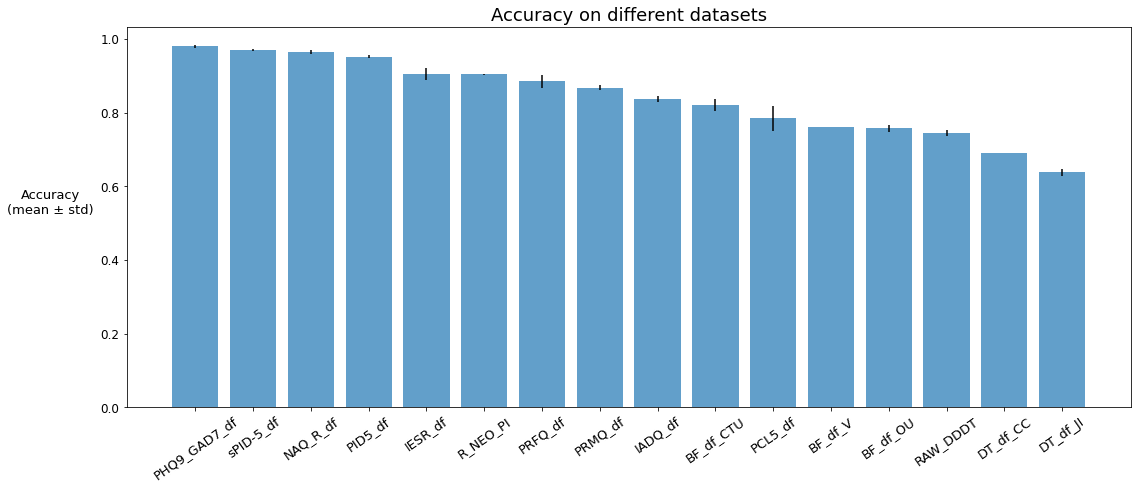

In [30]:
summary_graphs.accuracy_barplot(mis_summary, save = True, prefix = "MIS")

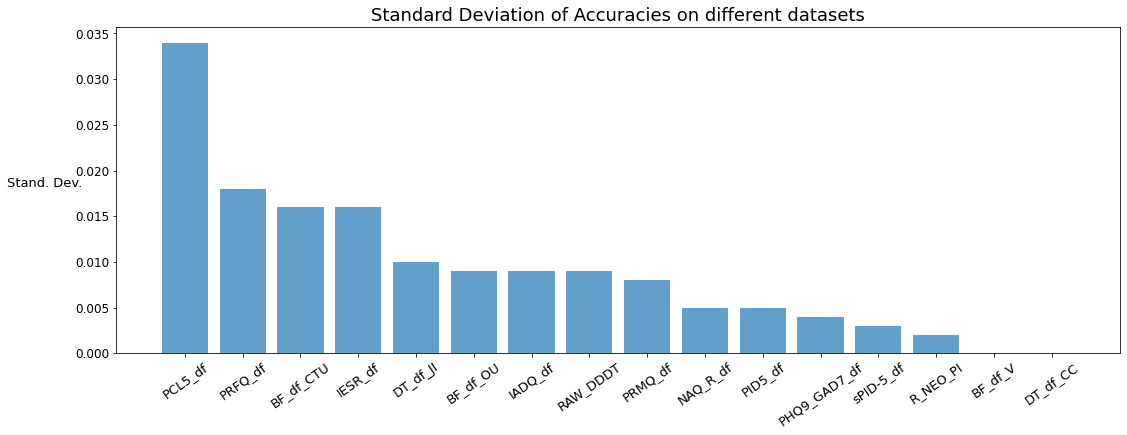

In [31]:
summary_graphs.accuracy_std(mis_summary, save = True, prefix = "MIS")

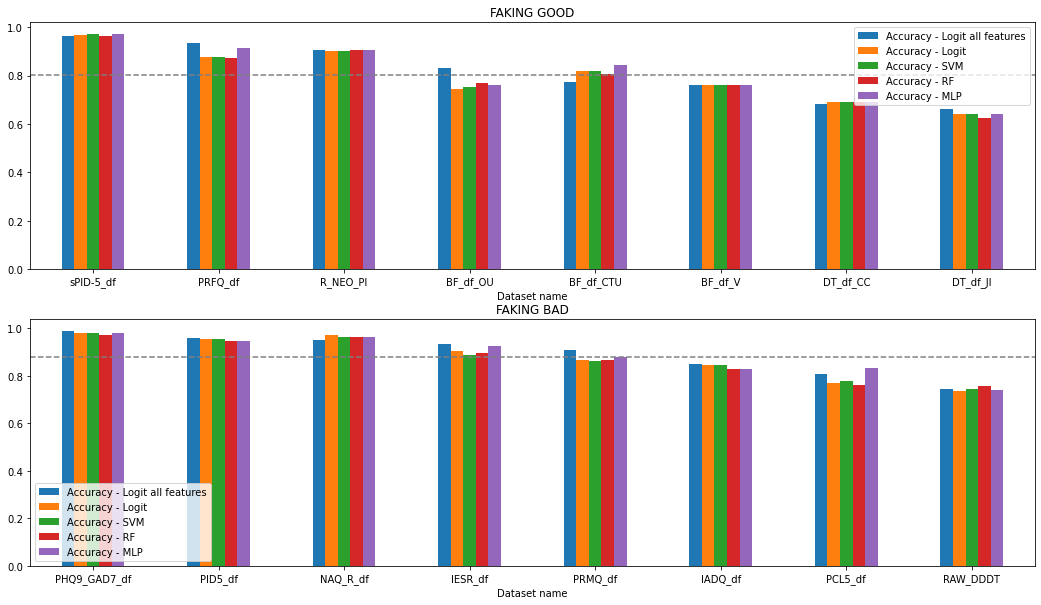

In [32]:
summary_graphs.faking_type_comparison(mis_summary, prefix = "MIS", save = True)

### COMPARISON BETWEEN APPROACHES

In [33]:
summ1 = pca_summary.copy()
summ1.columns = [f"{c}_pca" if c != "Dataset name" else c for c in pca_summary.columns]
summ2 = pimp_summary.copy()
summ2.columns = [f"{c}_permimp" if c != "Dataset name" else c for c in pimp_summary.columns]
summ3 = mis_summary.copy()
summ3.columns = [f"{c}_mutinfo" if c != "Dataset name" else c for c in mis_summary.columns]

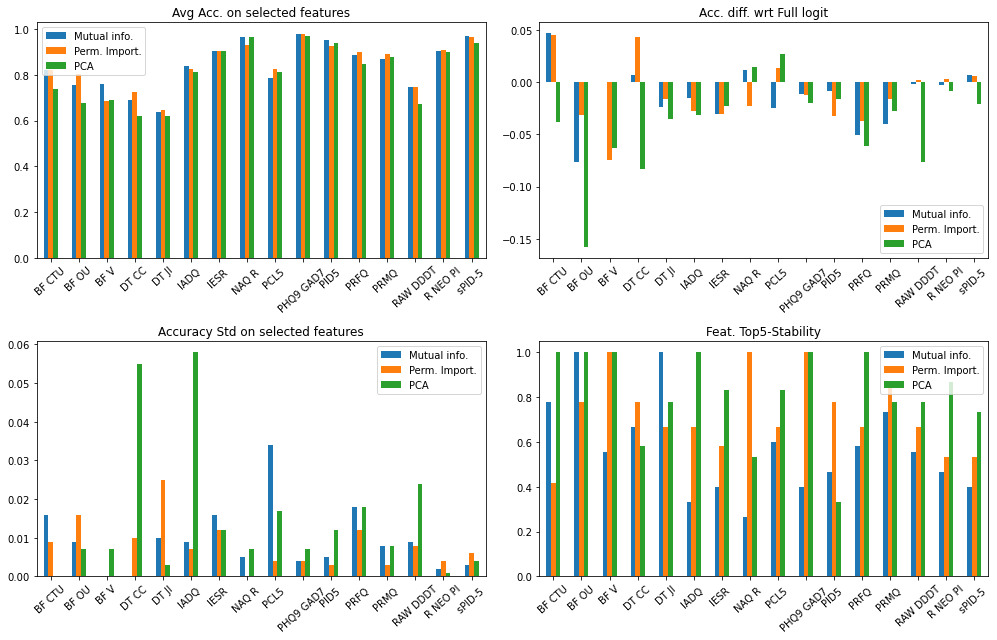

In [34]:
summary_merge = summ1.merge(summ2, on = "Dataset name",
                            how = "inner").merge(summ3, on = "Dataset name",
                                                 how = "inner")

xax_labels = summary_merge["Dataset name"].str.replace("_", " ")\
             .str.replace("df", "").str.replace("  ", " ")

fig, ax = plt.subplots(2, 2, figsize = (14, 9))
summary_merge.rename(columns = {"Avg Acc. on selected features_pca": "PCA",
                                "Avg Acc. on selected features_mutinfo": "Mutual info.",
                                "Avg Acc. on selected features_permimp": "Perm. Import."})\
             .plot(x = "Dataset name", y = ["Mutual info.", "Perm. Import.", "PCA"],
                   kind = "bar", rot = 0, ax = ax[0, 0],
                   title = "Avg Acc. on selected features")

summary_merge.rename(columns = {"Acc. diff. wrt Full logit_pca": "PCA",
                                "Acc. diff. wrt Full logit_mutinfo": "Mutual info.",
                                "Acc. diff. wrt Full logit_permimp": "Perm. Import."})\
             .plot(x = "Dataset name", y = ["Mutual info.", "Perm. Import.", "PCA"],
                   kind = "bar", rot = 0, ax = ax[0, 1],
                   title = "Acc. diff. wrt Full logit")

summary_merge.rename(columns = {"Accuracy Std on selected features_pca": "PCA",
                                "Accuracy Std on selected features_mutinfo": "Mutual info.",
                                "Accuracy Std on selected features_permimp": "Perm. Import."})\
             .plot(x = "Dataset name", y = ["Mutual info.", "Perm. Import.", "PCA"],
                   kind = "bar", rot = 0, ax = ax[1, 0],
                   title = "Accuracy Std on selected features")

summary_merge.rename(columns = {"Feat. Top5-Stability_pca": "PCA",
                                "Feat. Top5-Stability_mutinfo": "Mutual info.",
                                "Feat. Top5-Stability_permimp": "Perm. Import."})\
             .plot(x = "Dataset name", y = ["Mutual info.", "Perm. Import.", "PCA"],
                   kind = "bar", rot = 0, ax = ax[1, 1],
                   title = "Feat. Top5-Stability")

ax[0, 0].set_xticklabels(xax_labels, rotation = 42)
ax[0, 1].set_xticklabels(xax_labels, rotation = 42)
ax[1, 0].set_xticklabels(xax_labels, rotation = 42)
ax[1, 1].set_xticklabels(xax_labels, rotation = 42)

ax[0, 0].set(xlabel = None)
ax[0, 1].set(xlabel = None)
ax[1, 0].set(xlabel = None)
ax[1, 1].set(xlabel = None)

plt.tight_layout()

#plt.show()
plt.savefig(f".\\images\\Overall_comparison.jpg", dpi = 300)

In [50]:
print("Standard Deviation")
summary_merge[["Accuracy Std on selected features_pca",
               "Accuracy Std on selected features_permimp",
               "Accuracy Std on selected features_mutinfo"]].describe()\
            .loc[["mean", "min",
                  "max"]].rename(columns = {"Accuracy Std on selected features_pca": "PCA",
                                            "Accuracy Std on selected features_permimp": "PERM. IMP.",
                                            "Accuracy Std on selected features_mutinfo": "JMIM"}).applymap(lambda v:
                                                                                                           round(v, 4))

Standard Deviation


,PCA,PERM. IMP.,JMIM
mean,0.015,0.0077,0.0093
min,0.000,0.0000,0.0000
max,0.058,0.0250,0.0340


In [52]:
print("Top-5 stability")
summary_merge[["Feat. Top5-Stability_pca",
               "Feat. Top5-Stability_permimp",
               "Feat. Top5-Stability_mutinfo"]].describe()\
            .loc[["mean", "min",
                  "max"]].rename(columns = {"Feat. Top5-Stability_pca": "PCA",
                                            "Feat. Top5-Stability_permimp": "PERM. IMP.",
                                            "Feat. Top5-Stability_mutinfo": "JMIM"}).applymap(lambda v:
                                                                                              round(v, 4))

Top-5 stability


,PCA,PERM. IMP.,JMIM
mean,0.8156,0.7251,0.5754
min,0.3330,0.4170,0.2670
max,1.0000,1.0000,1.0000


---
---
---